# Problem Set 2 Solutions

In [175]:
# Basic system and data packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import time

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from pandas.plotting import scatter_matrix
import seaborn as sns

# Modeling packages
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso, LassoLarsIC, LassoLarsCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, classification_report, confusion_matrix, roc_auc_score, plot_roc_curve, make_scorer, recall_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS # also available in latest version of sklearn (0.24)
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LassoLarsIC, LassoLarsCV

## Problem 1: Linear Regression
Credit for Problem 1 solution shown here: Kaitlyn Koehler, Spring 2021

### This subsection revisits Problem 5 in Problem Set 1 (so that you have a proper background for this)
Import the training data into the notebook:

In [159]:
# Importing training data
data=pd.read_csv('data/Massachusetts_Census_Data_estimation.csv')

**a. Data relavent to explaining average vehicle ownership per household:**
I started with creating a matrix plot of the median and mean variables in the data set. These are the variables that might be relevant to explaining the average vehicle ownership per household (response variable) without any normalization. After some visual analysis, I chose the variables that appear to have the strongest correlation with the repsonse variable:
- Median household income - positive correlation
- Mean travel time to work - weaker positive correlation 
- Average household size - positive correlation

There might also be variables that are relevant if normalized by total population in each observation. I brainstormed possible revalent variables to be normalized:
- race (ex. percentage white)
- age (ex. percentage 25 yrs and older)
- Income (ex. percentage making over $50,000 a year)

Some variables might have a linear relationship if transformed. One example would be to do a log transformation on the total population. Total population could be revalant to the repsonse variable because in places with large population (such as cities), people are less likely to own cars. I would expect a negative correlation between total population and average vehciles owned.

Matrix Scatter Plot of Median/Mean Variables & Average Vehicle Ownership:


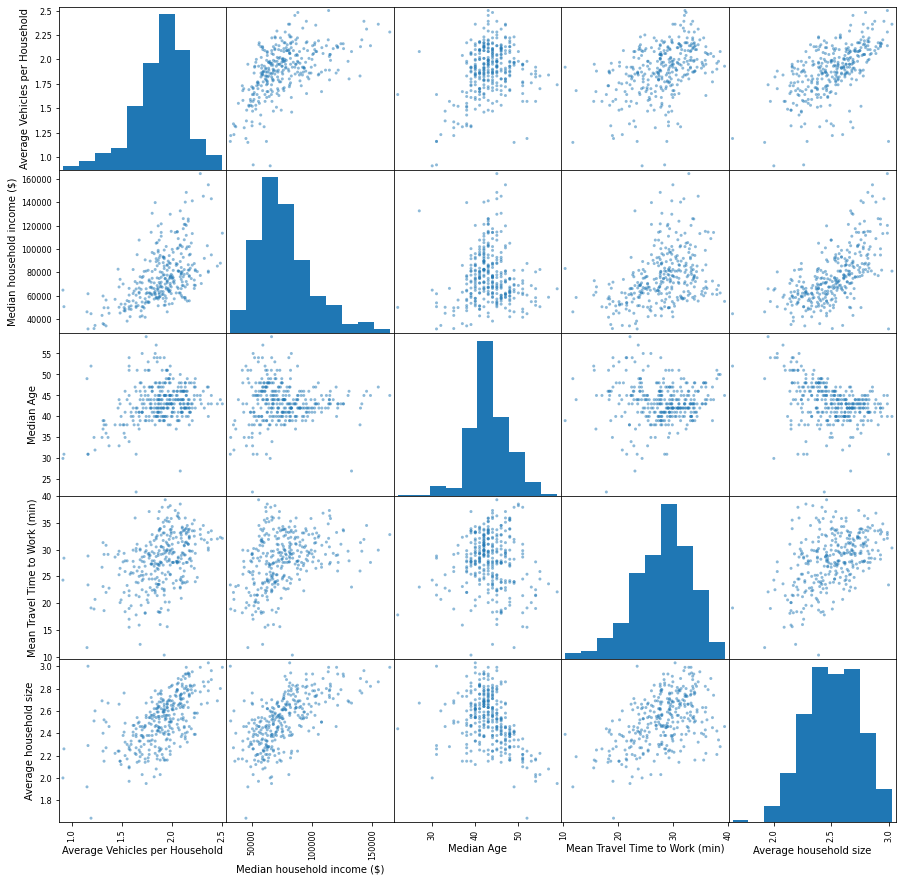

In [163]:
# Matrix Plot of Median/Mean Variables & Average Vehicle Ownership per Household
data_subset=data.loc[:,['Average Vehicles per Household','Median household income ($)',
                        'Median Age','Mean Travel Time to Work (min)',
                        'Average household size']]

print('Matrix Scatter Plot of Median/Mean Variables & Average Vehicle Ownership:')
scatter_matrix(data_subset,figsize=(15, 15)); #scatter matrix plot

**b. Specification of explanatory variable:**
In the below code I normalized some of the varibles by population and transformed the total population. Then, I created a matrix plot of these modified variable and choose the ones that had the best visual correlation to the response variable. After this analysis, and considering the variable analysed above, I chose the following predictor variables for my model:
1. Mean travel time to work
2. Median household income
3. Average household size
4. Percent of population that is white
5. Percent of household making over 50,000 a year
6. Total population log normalized

I then analyzed these variables for goodness of fit using an OLS regression on each predictor variable and the response variable (see second code cell below). The statistics from the OLS regressions show a good p-values for all variables analyzed. The R^2 values were not very good for all variables. The variable with the best R^2 value is percent of household making over $50,000 a year with an R^2 of 0.457. 

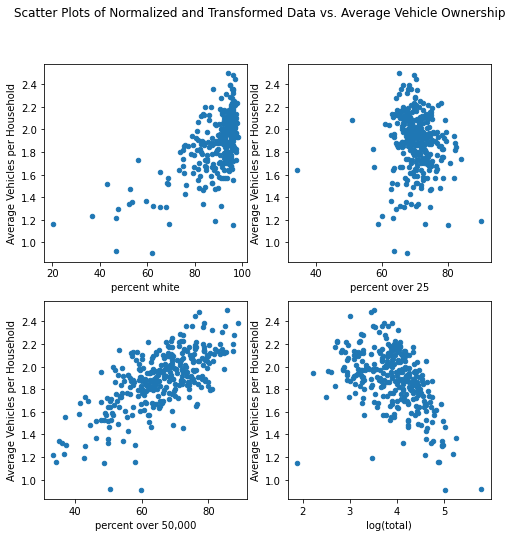

In [164]:
# Normalize/transform data and plot

# Race: Percent of population that is white
total=data.loc[:,'Total'] #race data taken for entire population
pct_white=(data.loc[:,'White']/total)*100
data["percent white"]=pct_white

# Age: Percent over 25 year old - taken for entire population
pop_25=data.loc[:,'25 to 34 years':'75 years and over']
pct_25=(pop_25.sum(axis=1)/total)*100
data["percent over 25"]=pct_25

# Income: percent of households making over $50,000 a year
tot_house=data.loc[:,'Total households'] #income data taken for total households reported
income_50=data.loc[:,'50,000 to 59,999':'200,000 and up']
pct_50=(income_50.sum(axis=1)/tot_house)*100
data["percent over 50,000"]=pct_50

# Total Population log10 transform to make linear
total_log=np.log10(total)
data["log(total)"]=total_log


fig, axs = plt.subplots(2, 2)
fig.suptitle('Scatter Plots of Normalized and Transformed Data vs. Average Vehicle Ownership')
fig.set_figheight(8)
fig.set_figwidth(8)
data.plot.scatter(x='percent white', y='Average Vehicles per Household',ax=axs[0,0]);
data.plot.scatter(x='percent over 25', y='Average Vehicles per Household',ax=axs[0,1]);
data.plot.scatter(x='percent over 50,000', y='Average Vehicles per Household',ax=axs[1,0]);
data.plot.scatter(x='log(total)', y='Average Vehicles per Household',ax=axs[1,1]);

data_train=data #Used later in code

In [165]:
# Statistical Analysis: OLS Regression for each predictor variable

eqn1 = 'Q("Average Vehicles per Household") ~ Q("Mean Travel Time to Work (min)")'
eqn2 = 'Q("Average Vehicles per Household") ~ Q("Median household income ($)")'
eqn3 = 'Q("Average Vehicles per Household") ~ Q("Average household size")'
eqn4 = 'Q("Average Vehicles per Household") ~ Q("percent white")'
eqn5 = 'Q("Average Vehicles per Household") ~ Q("percent over 50,000")'
eqn6 = 'Q("Average Vehicles per Household") ~ Q("log(total)")'
results1 = smf.ols(eqn1, data).fit()
results2 = smf.ols(eqn2, data).fit()
results3 = smf.ols(eqn3, data).fit()
results4 = smf.ols(eqn4, data).fit()
results5 = smf.ols(eqn5, data).fit()
results6 = smf.ols(eqn6, data).fit()
print(results1.summary())
print(results2.summary())
print(results3.summary())
print(results4.summary())
print(results5.summary())
print(results6.summary())

                                     OLS Regression Results                                    
Dep. Variable:     Q("Average Vehicles per Household")   R-squared:                       0.179
Model:                                             OLS   Adj. R-squared:                  0.177
Method:                                  Least Squares   F-statistic:                     69.66
Date:                                 Mon, 07 Mar 2022   Prob (F-statistic):           2.16e-15
Time:                                         16:06:51   Log-Likelihood:                 10.531
No. Observations:                                  321   AIC:                            -17.06
Df Residuals:                                      319   BIC:                            -9.520
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                                        

**c. Analyze the explanatory variables to discard potential collinearity problems**

I analyzed the 6 chosen predictor variables for collinearity using a scatter matrix for visual analysis and a correlation matrix for statistical analysis. One pair of variables showed an obvious collinearity problem: Median household income and percent of household making over $50,000 a year. The scatter plot of these two variable looks to be almost perfectly linear and the correlation number is almost 1. 

I decided to eliminate the Median household income because it seems to be a less significant predictor from the statistical analysis above.

Here is a list of the final 5 predictor variables that I will use in my models:
1. Mean travel time to work
2. Average household size
3. Percent of population that is white
4. Percent of household making over 50,000 a year
5. Total population log normalized


,Mean Travel Time to Work (min),Median household income ($),Average household size,percent white,"percent over 50,000",log(total)
Mean Travel Time to Work (min),1.000000,0.362404,0.473896,0.212660,0.411383,-0.107922
Median household income ($),0.362404,1.000000,0.624695,0.187197,0.902045,0.060639
Average household size,0.473896,0.624695,1.000000,-0.005420,0.620474,0.201627
percent white,0.212660,0.187197,-0.005420,1.000000,0.326146,-0.580455
"percent over 50,000",0.411383,0.902045,0.620474,0.326146,1.000000,-0.010702
log(total),-0.107922,0.060639,0.201627,-0.580455,-0.010702,1.000000


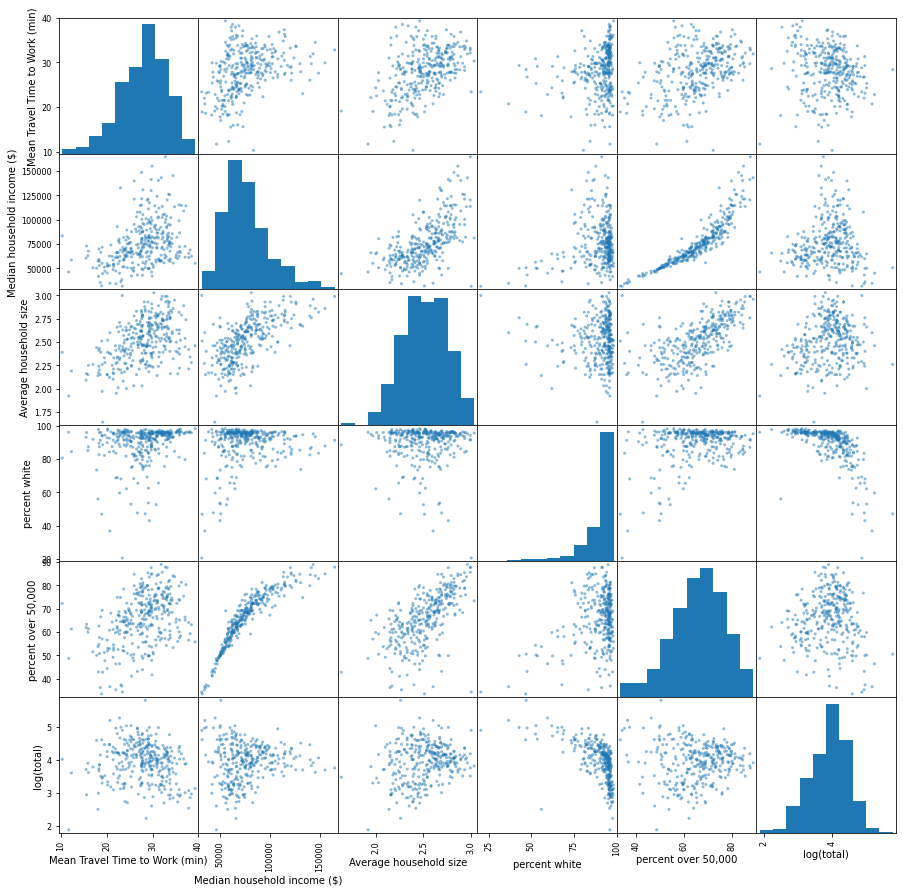

In [166]:
scatter_matrix(data.loc[:,['Mean Travel Time to Work (min)',
                           'Median household income ($)',
                           'Average household size',
                           'percent white',
                           'percent over 50,000',
                           'log(total)']],figsize=(15, 15));
data.loc[:,['Mean Travel Time to Work (min)',
            'Median household income ($)',
            'Average household size',
            'percent white', 
            'percent over 50,000',
            'log(total)']].corr()

#correlation between percent over 50,000 and mean income is almost one. Remove one of these. Lets eliminate median household income

### Part 1.1: Model Exploration

**a. Proposed models:** 
1. Ordinary Least Squares (OLS) Linear Regression
2. Forward Stepwise Selection
3. Ridge Regresseion
4. Lasso Method


In [167]:
# Defining the training data predictor variables (X) and response variable (y)
X=data.loc[:,['Mean Travel Time to Work (min)',
              'Average household size', 
              'percent white',
              'log(total)',
              'percent over 50,000',]] # Predictor variables

y=data.loc[:,'Average Vehicles per Household'] # Reponse variable
#dataframe = pd.concat([X, y], axis=1)
#set up Dataframe for model statistics:
modelStats=pd.DataFrame(index=['model1', 'model2', 'model3', 'model4'],
                        columns=["model", "R-squared", "adj R-squared", "AIC", "BIC", "Cp"]) 

**Model 1: OLS Linear Regression with Every Predictor Variable**

The following code shows a OLS linear regression including every perdictor variable. The OLS regression results summary is shown below. The R^2 and adj R^2 are high (0.8). Also, the p-values for each predictor variable is zero, except for the mean travel time to work which has a p-value of 0.146 (which is still acceptable). Overall, I am fairly happy with this model.

In [170]:
# Model 1: OLS Linear Regression with every predictor variable
model1=sm.OLS(y,sm.add_constant(X)).fit()
print(model1.summary())

n=len(y)
p=X.shape[1]
RSS=model1.ssr
sigma2=RSS/(n-1) # equation 8 from PS-1 Hints
# I had to manually calculate AIC, BIC, and Cp for the OLS regression becasue ...
# statsmodel doesn't seem to use the equations we reviewed in class (from ISLR)
AIC=(1/(n*sigma2))*(RSS+(2*p*sigma2)) 
BIC=(1/(n*sigma2))*(RSS+(np.log(n)*p*sigma2))
Cp=(1/n)*(RSS+2*p*sigma2)

modelStats.loc['model1']={"model":'OLS', 
                          "R-squared":model1.rsquared, 
                          "adj R-squared":model1.rsquared_adj, 
                          "AIC":AIC, 
                          "BIC":BIC, 
                          "Cp":Cp}

                                  OLS Regression Results                                  
Dep. Variable:     Average Vehicles per Household   R-squared:                       0.843
Model:                                        OLS   Adj. R-squared:                  0.840
Method:                             Least Squares   F-statistic:                     337.1
Date:                            Mon, 07 Mar 2022   Prob (F-statistic):          4.17e-124
Time:                                    16:07:48   Log-Likelihood:                 275.53
No. Observations:                             321   AIC:                            -539.1
Df Residuals:                                 315   BIC:                            -516.4
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025    

**Model 2: Forward Stepwise Selection**

The below code shows a forward stepwise selection. This selection model starts with a base model $M_0$, and adds just one predictor variable to find the best model $M_1$ based on the R^2 value. Then, it continues to adds 1 predictor variable to the previous best model to find the best $M_k$ model. Then, all the overall best model is choosen from the $M_k$ models using the adjusted R^2.

The forward stepwise selection here choose the $M_5$ as the overall best model. This is an OLS linear regression model that contains all 5 of the predictor variable, so the result is identical to the regular OLS linear regression model above (Model 1). This was unexpected because I through this method would choose an $M_4$ model without the "Mean Travel Time to Work" variable since this variable seems to be the least statistically significant. But, it appears this variable seems to be significant enough to improve the over model.

In [171]:
# Model 2: Forward Stepwise Selection - same result as OLS

# Functions
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    x=X[list(feature_set)]
    model = sm.OLS(y,sm.add_constant(x))
    regr = model.fit()
    RSS=regr.ssr
    adjR2 = regr.rsquared_adj
    return {"model":regr, "RSS":RSS, "adj_R2":adjR2}

def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        
        results.append(processSubset(predictors+[p]))
        
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS #This should be lowest RSS or highest R^2!
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    #print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

# Code
models_fwd = pd.DataFrame(columns=["RSS", "adj_R2", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    variables=models_fwd.loc[i]["model"].model.exog_names
    predictors=variables[1:]
    
    
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
print('Best model from each iteration:')
print(models_fwd)
models_fwd['adj_R2'].argmin()
index=models_fwd['adj_R2'].argmax()+1
best_model_M=models_fwd.loc[index] #best model of Ms
print('The overall best model is model with ' + str(index) + ' predictor variables becasue it has the highest adjusted R^2')
model2=best_model_M['model']
print(model2.summary())


n=len(y)
p=X.shape[1]
RSS = model2.ssr
sigma2=RSS/(n-1) # equation 8 from PS-1 Hints
# I had to manually calculate AIC, BIC, and Cp for the OLS regression becasue ...
# statsmodel doesn't seem to use the equations we reviewed in class (from ISLR)
AIC=(1/(n*sigma2))*(RSS+(2*p*sigma2))
BIC=(1/(n*sigma2))*(RSS+(np.log(n)*p*sigma2))
Cp=(1/n)*(RSS+2*p*sigma2)

modelStats.loc['model2']={"model":'Forward Stepwise',
                          "R-squared":model2.rsquared, 
                          "adj R-squared":model2.rsquared_adj, 
                          "AIC":AIC, 
                          "BIC":BIC, 
                          "Cp":Cp}

Total elapsed time: 0.04576921463012695 seconds.
Best model from each iteration:
         RSS    adj_R2                                              model
1  11.634684  0.455747  <statsmodels.regression.linear_model.Regressio...
2   7.090896  0.667255  <statsmodels.regression.linear_model.Regressio...
3   4.674002  0.779978  <statsmodels.regression.linear_model.Regressio...
4   3.399352  0.839474  <statsmodels.regression.linear_model.Regressio...
5   3.376606  0.840042  <statsmodels.regression.linear_model.Regressio...
The overall best model is model with 5 predictor variables becasue it has the highest adjusted R^2
                                  OLS Regression Results                                  
Dep. Variable:     Average Vehicles per Household   R-squared:                       0.843
Model:                                        OLS   Adj. R-squared:                  0.840
Method:                             Least Squares   F-statistic:                     337.1
Date:       

**Model 3: Ridge Regression Method**

Ridge Regression method adds a penalty term to the RSS, which is minimized to determine the coefficents. This reduces the coefficients of irrelevant predictors. This is know as a shrinkage method. Ridge regression can shrink the coefficients, but not eliminate variable entirely.

The code below shows the Ridge Regression applied to my model predictors. The resulting coefficients for each variable and a histogram representing the feature importance is shown below. The alpha (or $\lambda$) chosen by the ridge method and the R^2 value is also reported below. The R^2 value of 0.84 is good. The coefficient that was shrunk the most was "Mean Travel Time to Work", which was expected.

Best alpha using built-in Ridge: 0.014563
Best score (R^2) using built-in Ridge: 0.842393
Coefficients:
Mean Travel Time to Work (min)   -0.001586
Average household size            0.552673
percent white                     0.007963
log(total)                       -0.166076
percent over 50,000               0.006247
dtype: float64
y-intercept (B0): 0.07171316706715425


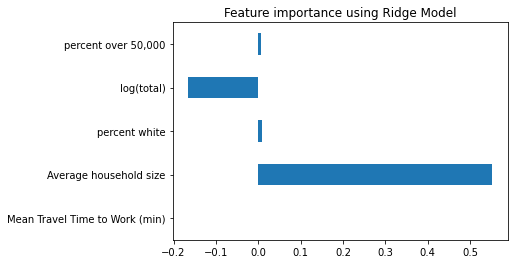

In [176]:
# Model 3: Ridge Regression Method
model3 = RidgeCV(normalize=True,alphas=np.logspace(-6, 6),cv=10).fit(X, y) #Note that normalize is deprecated (warnings silenced)
print("Best alpha using built-in Ridge: %f" % model3.alpha_) 
print("Best score (R^2) using built-in Ridge: %f" %model3.score(X,y)) # score is R^2
coef3=pd.Series(model3.coef_, index = X.columns)
coef3.plot(kind = "barh")
plt.title("Feature importance using Ridge Model");
print('Coefficients:')
print(coef3)
print('y-intercept (B0): '+str(model3.intercept_))

R2=model3.score(X,y)
n=len(y)
p=X.shape[1]
R2_adj=1 - (1-R2)*(n-1)/(n-p-1)
RSS = np.sum((model3.predict(X)-y)**2)
sigma2=RSS/(n-1)
AIC=(1/(n*sigma2))*(RSS+(2*p*sigma2))
BIC=(1/(n*sigma2))*(RSS+(np.log(n)*p*sigma2))
Cp=(1/n)*(RSS+2*p*sigma2)

modelStats.loc['model3']={"model":'Ridge', 
                          "R-squared":R2, 
                          "adj R-squared":R2_adj, 
                          "AIC":AIC, 
                          "BIC":BIC, 
                          "Cp":Cp}


**Model 4: Lasso Method**
Lasso method also penalizes coefficients or irrelevant predictors by shrinking them. But, unlike the Ridge method, the Lasso method can shrink coefficients to zero.

The Lasso method is applied below. The resulting coefficients for each variable and a histogram representing the feature importance is shown below. The alpha (or $\lambda$) chosen by the Lasso method and the R^2 value is also reported below. The R^2 value of 0.84 is good. The results are very similar to the Ridge method. The coefficient that was shrunk the most was "Mean Travel Time to Work", which was expected. But, I am surprised that "Mean Travel Time to Work" wasn't totally eliminated (coeff=0). 

Best alpha using built-in Lasso: 0.000010
Best score (R^2) using built-in Lasso: 0.842538
Lasso picked 5 variables and eliminated the other 0 variables.
Coefficients:
Mean Travel Time to Work (min)   -0.001876
Average household size            0.566677
percent white                     0.008032
log(total)                       -0.168877
percent over 50,000               0.006169
dtype: float64


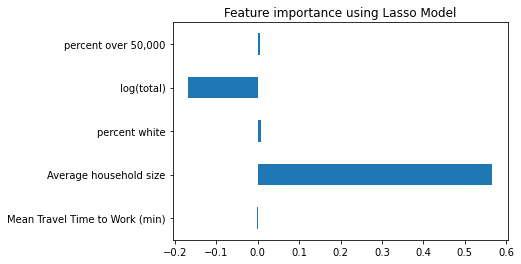

In [177]:
# Model 4: Lasso Method

model4 = LassoCV(normalize=True, cv=10).fit(X, y)
#n_alphas: number of alpha tested, default 100
#Lasso defult tolerance (tol) for the optimization of alpha = 1e-4
print("Best alpha using built-in Lasso: %f" % model4.alpha_) # lamda
print("Best score (R^2) using built-in Lasso: %f" % model4.score(X,y)) # What does this mean? Return the coefficient of determination R^2 of the prediction?
coef4=pd.Series(model4.coef_, index = X.columns)
print("Lasso picked " + str(np.sum(coef4 != 0)) + " variables and eliminated the other " +  str(np.sum(coef4 == 0)) + " variables.")
coef4.plot(kind = "barh")
plt.title("Feature importance using Lasso Model");
#print("Number of interations run by the cordinate decent solver to reach optimal alpha: " + str(model4.n_iter_))
print('Coefficients:')
print(coef4)

R2=model4.score(X,y)
n=len(y)
p=X.shape[1]
R2_adj=1 - (1-R2)*(n-1)/(n-p-1)
RSS = np.sum((model4.predict(X)-y)**2)
sigma2=RSS/(n-1)
AIC=(1/(n*sigma2))*(RSS+(2*p*sigma2))
BIC=(1/(n*sigma2))*(RSS+(np.log(n)*p*sigma2))
Cp=(1/n)*(RSS+2*p*sigma2)

modelStats.loc['model4']={"model":'Lasso', 
                          "R-squared":R2, 
                          "adj R-squared":R2_adj, 
                          "AIC":AIC, 
                          "BIC":BIC, 
                          "Cp":Cp}


**Model Comparison**

Below is the printed model statistics for each model. The Adujsued R^2 and Cp are plotted as bar plots. The 4 models all have very similar statitics. This is surprising to me because I though the Ridge and Lasso method would provide better fit models due to the addition of the penalty term. The best peforming for the training data model appears to be the OLS model (which is the same as the forward stepwise model) by a very slim margin.

$M_B$ = Model 1 (OLS)

                   model R-squared adj R-squared       AIC       BIC        Cp
model1               OLS  0.842541      0.840042  1.028037  1.086783  0.010848
model2  Forward Stepwise  0.842541      0.840042  1.028037  1.086783  0.010848
model3             Ridge  0.842393      0.839891  1.028037  1.086783  0.010858
model4             Lasso  0.842538      0.840038  1.028037  1.086783  0.010848


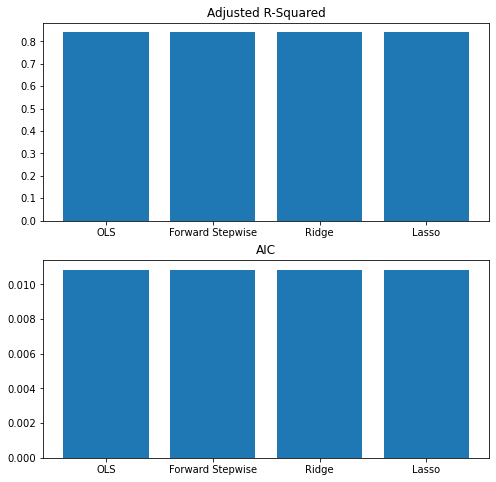

In [178]:
print(modelStats)
fig, axs = plt.subplots(2,figsize=(8,8));
axs[0].bar(modelStats['model'],modelStats['adj R-squared']);
axs[0].set_title('Adjusted R-Squared');
axs[1].bar(modelStats['model'],modelStats['Cp']);
axs[1].set_title('AIC');

### Part 1.2 Forecasting and Analyzing Residuals
**a. Using all the models you estimated, forecast the average number of vehicles per household in
the 30 validation towns.**

In the below code, the test data is loaded and the 4 models from above are used to predict the reponse (average number of vehicles per household). The predicted response from each model is plotted agaist the actual response. It appears the performance of all 4 models on the test data is very similar, which is expected based on their similar performances on the training data. In these plots, the points laying near/on the red line indicate where the model predicted the response ver well.

The test MSE for each model is also calculated (see second code block below). The test MSE is very low (close to zero) for each model, which indicates good performace. Based on this analysis, the best fit model is still the OLS model.

$M_B'$ = Model 1 (OLS)

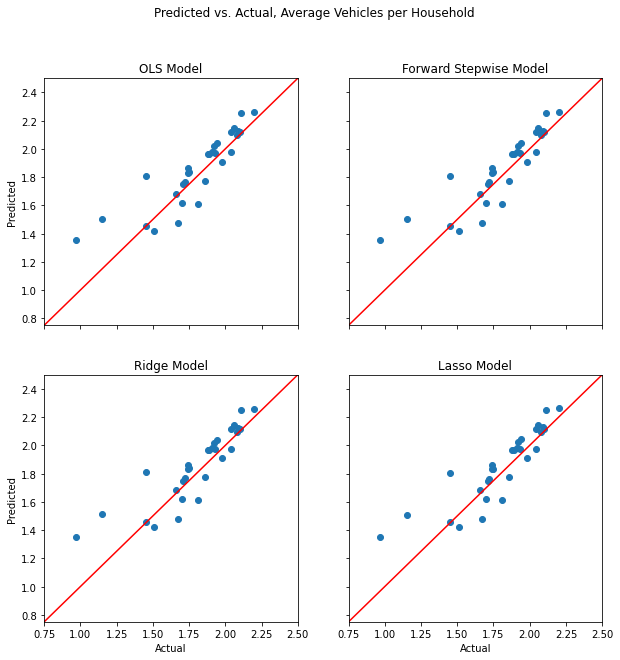

In [23]:
# Importing the test data
data_test=pd.read_csv('data/Massachusetts_Census_Data_forecast.csv')

# Normalize/transform relevant data
# Race: percentage white
total=data_test.loc[:,'Total'] #race data taken for entire population
pct_white=(data_test.loc[:,'White']/total)*100
data_test["percent white"]=pct_white

# Income: percent over $50,000 & percent over $60,000 & percent over $75,000
tot_house=data_test.loc[:,'Total households'] #income data taken for total households reported
income_50=data_test.loc[:,'50,000 to 59,999':'200,000 and up']
pct_50=(income_50.sum(axis=1)/tot_house)*100
data_test["percent over 50,000"]=pct_50

# Total Population normalize to make linear
total=data_test.loc[:,'Total'] #race data taken for entire population
total_norm=np.log10(total)
data_test["log(total)"]=total_norm

X_test=np.array(data_test.loc[:,['Mean Travel Time to Work (min)',
                                 'Average household size', 
                                 'percent white',
                                 'log(total)',
                                 'percent over 50,000']]) # Define Predictors matrix X
X_test2=np.array(data_test.loc[:,['percent over 50,000', 
                                  'log(total)',
                                  'Average household size',
                                  'percent white',
                                  'Mean Travel Time to Work (min)']])
                         
y_test=np.array(data_test.loc[:,'Average Vehicles per Household']) # Response y

# Predict the repsonse variable (using each model)
y_predict1=model1.predict(sm.add_constant(X_test))
y_predict2=model2.predict(sm.add_constant(X_test2))
y_predict3=model3.predict(X_test) 
y_predict4=model4.predict(X_test)

# Scatter plots for predicted vs. actaul response for each model
fig, ax = plt.subplots(2,2)
fig.suptitle('Predicted vs. Actual, Average Vehicles per Household')
fig.set_figheight(10)
fig.set_figwidth(10)
ax[0,0].scatter(y_test,y_predict1)
ax[0,0].plot([0.75,2.5],[0.75,2.5],'r-')
ax[0,0].set_title('OLS Model')
ax[0,1].scatter(y_test,y_predict2)
ax[0,1].plot([0.75,2.5],[0.75,2.5],'r-')
ax[0,1].set_title('Forward Stepwise Model')
ax[1,0].scatter(y_test,y_predict3)
ax[1,0].plot([0.75,2.5],[0.75,2.5],'r-')
ax[1,0].set_title('Ridge Model')
ax[1,1].scatter(y_test,y_predict4)
ax[1,1].plot([0.75,2.5],[0.75,2.5],'r-')
ax[1,1].set_title('Lasso Model')

for axs in ax.flat:
    axs.set(xlabel='Actual', ylabel='Predicted', xlim=(0.75,2.5), ylim=(0.75,2.5))
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

Test MSE:
                       MSE
OLS               0.020749
Forward Stepwise  0.020749
Ridge             0.020793
Lasso             0.020785


Text(0.5, 1.0, 'Test MSE')

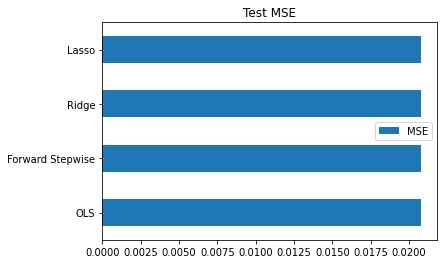

In [24]:
# Calculate Test MSE
testStat=pd.DataFrame(index=['OLS', 'Forward Stepwise', 'Ridge', 'Lasso'])
n=len(y_test)
testStat.at['OLS','MSE']=(1/n)*np.sum((y_test-y_predict1)**2)
testStat.at['Forward Stepwise','MSE']=(1/n)*np.sum((y_test-y_predict2)**2)
testStat.at['Ridge','MSE']=(1/n)*np.sum((y_test-y_predict3)**2)
testStat.at['Lasso','MSE']=(1/n)*np.sum((y_test-y_predict4)**2)

print('Test MSE:')
print(testStat) # MSE closer to zero is better
testStat.plot(kind = 'barh');
plt.title('Test MSE')

**b. Provide confidence intervals of the predicted values using $M_B'$, and check if the actual average
numbers of vehicles per household belong to the intervals.**

The 95% confidence intervals for the predicted mean response of the test data is shown below. The actual responses inside and outside the confidence interval are tabulated. I was surprised that actual responses for 26 out of the 30 observations were outside the 95% confidence interval. 

In [25]:
# Get the 95% confidence intervals of the mean response.
predictions=model1.get_prediction(sm.add_constant(X_test))
frame=predictions.summary_frame() #alpha = 0.05 default (95% confidence intervals)
CI_analysis=pd.DataFrame(index=data_test['Town'])
CI_analysis['Lower CI']=np.array(frame.mean_ci_lower)
CI_analysis['Upper CI']=np.array(frame.mean_ci_upper)
CI_analysis['Actual']=np.array(y_test)

# indicies predictions outside and inside 95% confidence interval
logic_index=np.where((y_test>np.array(frame.mean_ci_upper))| (y_test<np.array(frame.mean_ci_lower))) 
logic_index_inside=np.where(~((y_test>np.array(frame.mean_ci_upper))| (y_test<np.array(frame.mean_ci_lower))))

print('Number of predictions outside 95% confidence interval: ' + str(np.shape(logic_index)[1]) + ' out of ' + str(len(y_test)))
print('\n Response outside:')
print(CI_analysis.iloc[logic_index])
print('\n Response inside:')
print(CI_analysis.iloc[logic_index_inside])

Number of predictions outside 95% confidence interval: 26 out of 30

 Response outside:
             Lower CI  Upper CI  Actual
Town                                   
Amesbury     1.814286  1.854146    1.75
Athol        1.714972  1.779373    1.71
Brookfield   1.949572  1.980366    1.89
Brookline    1.467665  1.542770    1.15
Chelsea      1.269407  1.436420    0.97
Chicopee     1.386749  1.450724    1.51
Clinton      1.599495  1.637100    1.70
Dracut       1.890487  1.926226    1.98
Franklin     1.997743  2.042569    1.92
Goshen       2.105999  2.150089    2.09
Hancock      2.084697  2.151735    2.04
Hatfield     1.750153  1.797531    1.86
Leicester    1.958413  1.985562    1.93
Littleton    2.027160  2.056983    1.94
Mendon       2.240405  2.286718    2.20
Monroe       1.739902  1.872017    1.45
Natick       1.738544  1.787616    1.72
New Ashford  2.107606  2.184581    2.06
Norton       1.961977  1.997849    1.91
Orleans      1.577839  1.640571    1.81
Randolph     1.412498  1.541990 

**c. Plot and analyze the residuals for all 351 towns, indicating if the assumptions of normality
and homoscedasticity hold. If not, discuss how these issues may be addressed.**

The code below predicts the repsonse for all 351 towns using $M_B'$ (model 1: OLS). The residuals are calculated and plotted to analyze the normality and homoscedasticity.

The first plot below shows the residuals vs. fitted (predicted) values as a scatter plot. The fitted red line is almost vertical, representing that the linear fit used is a good approximation. There also appears to be constant variance (or scattering) on the error term, which represents homoscedasticity.

The second and third plot below show the residuals as a histogram and a probability plot. These two plots show that the residuals are normally distributed, indicating normality of the model. The R^2 term for the probability plot is 0.94, which represents very good normality.

Probability Plot R^2: 0.9417173315254236


/Users/katiekoehler/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


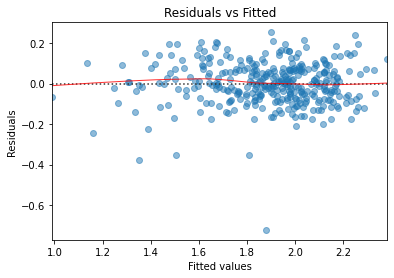

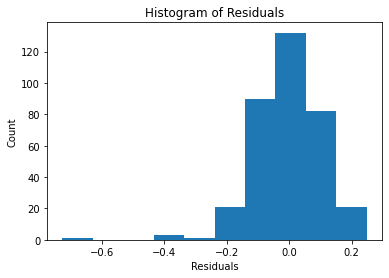

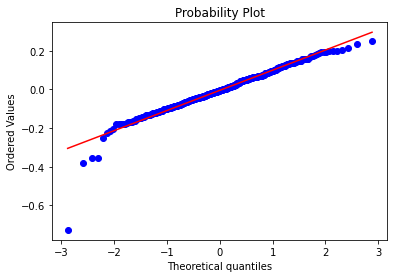

In [26]:
# Data for all 351 towns
data_all=pd.concat([data_train,data_test],ignore_index=True)
data_all=data_all.sort_values('Town')

# Normalize/transform data 
# Race: percentage white
total=data_all.loc[:,'Total'] #race data taken for entire population
pct_white=(data_all.loc[:,'White']/total)*100
data_all["percent white"]=pct_white

# Income: percent over $50,000 & percent over $60,000 & percent over $75,000
tot_house=data_all.loc[:,'Total households'] #income data taken for total households reported
income_50=data_all.loc[:,'50,000 to 59,999':'200,000 and up']
pct_50=(income_50.sum(axis=1)/tot_house)*100
data_all["percent over 50,000"]=pct_50

# Total Population normalize to make linear
total=data_all.loc[:,'Total'] #race data taken for entire population
total_norm=np.log10(total)
data_all["log(total)"]=total_norm

X_all=np.array(data_all.loc[:,['Mean Travel Time to Work (min)',
                                 'Average household size', 
                                 'percent white',
                                 'log(total)',
                                 'percent over 50,000']]) 

y_all=np.array(data_all.loc[:,'Average Vehicles per Household']) 

# model predicted values
y_hat_all = model1.predict(sm.add_constant(X_all))

# model residuals
residuals_all = y_all - y_hat_all

plot1 = plt.figure()
plot1.axes[0] = sns.residplot(y_hat_all,y_all,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});

plot1.axes[0].set_title('Residuals vs Fitted')
plot1.axes[0].set_xlabel('Fitted values')
plot1.axes[0].set_ylabel('Residuals');
# Linearity: there won’t be any apparent patterns in the scatterplot and the red line would be horizontal.
# this looks good. Linear fit is a good approximation
#Also appears to have homoscedasticity (constant variance on error term)

plot2=plt.figure()
plot2=plt.hist(residuals_all)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Count')

fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residuals_all, plot=ax, fit=True)
print('Probability Plot R^2: ' +str(r**2))
# We can apply normal probability plot to assess how the data (error) depart from normality visually: The good fit (r^2 = 0.94) indicates that normality is a reasonable approximation.



## Problem 2: Shrinkage methods exploration

### 1 (c) Plot the ridge regression estimate

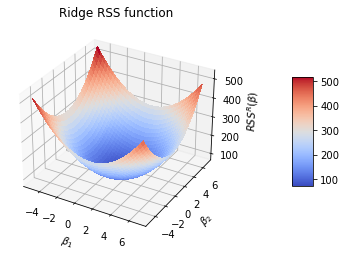

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y_1 = 8
y_2 = 5
la = 5
beta_1 = np.arange(-5, 7, 0.1)
beta_2 = np.arange(-5, 7, 0.1)
beta_1, beta_2 = np.meshgrid(beta_1, beta_2)
rss_ridge = (y_1 - beta_1)**2 + (y_2 - beta_2)**2 + la*(beta_1**2 + beta_2**2)

# Plot the surface.
surf = ax.plot_surface(beta_1, beta_2, rss_ridge, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlabel(r"$RSS^{R}(\beta)$")
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter('{x:3.0f}') #format appearance of z-axis ticks
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, orientation="vertical", pad=0.2)
plt.title('Ridge RSS function')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

### 1 (d) Plot the lasso regression estimate

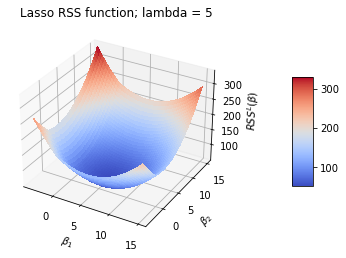

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y_1 = 8
y_2 = 5
la = 5
beta_1 = np.arange(-4, 15, 0.1)
beta_2 = np.arange(-4, 15, 0.1)
beta_1, beta_2 = np.meshgrid(beta_1, beta_2)
rss_ridge = (y_1 - beta_1)**2 + (y_2 - beta_2)**2 + la*(np.abs(beta_1) + np.abs(beta_2))

# Plot the surface.
surf = ax.plot_surface(beta_1, beta_2, rss_ridge, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlabel(r"$RSS^{L}(\beta)$")
#ax.set_zlim(0, 450)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter('{x:3.0f}') #format appearance of z-axis ticks
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, orientation="vertical", pad=0.2)
plt.title('Lasso RSS function; lambda = 5')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

Notice the subtle but visible differences between the ridge and lasso (sharp corners) objective functions in the plot. Let's generate a plot with a more extreme regularization (lambda):

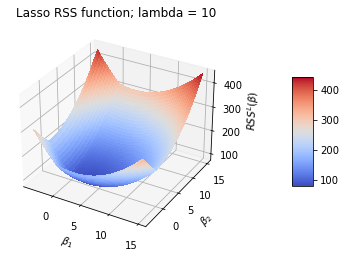

In [7]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y_1 = 8
y_2 = 5
la = 10
beta_1 = np.arange(-4, 15, 0.1)
beta_2 = np.arange(-4, 15, 0.1)
beta_1, beta_2 = np.meshgrid(beta_1, beta_2)
rss_ridge = (y_1 - beta_1)**2 + (y_2 - beta_2)**2 + la*(np.abs(beta_1) + np.abs(beta_2))

# Plot the surface.
surf = ax.plot_surface(beta_1, beta_2, rss_ridge, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlabel(r"$RSS^{L}(\beta)$")
#ax.set_zlim(0, 450)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter('{x:3.0f}') #format appearance of z-axis ticks
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, orientation="vertical", pad=0.2)
plt.title('Lasso RSS function; lambda = 10')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

We see that with greater regularization, the less relevant parameter $\beta_2$ is now 0. For greater clarity, we may observe the wireframe plot:

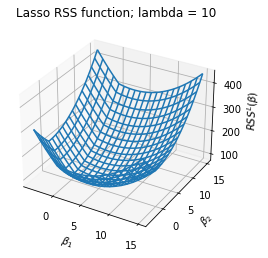

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
y_1 = 8
y_2 = 5
la = 10
beta_1 = np.arange(-4, 15, 0.1)
beta_2 = np.arange(-4, 15, 0.1)
beta_1, beta_2 = np.meshgrid(beta_1, beta_2)
rss_ridge = (y_1 - beta_1)**2 + (y_2 - beta_2)**2 + la*(np.abs(beta_1) + np.abs(beta_2))

# Plot the surface.
surf = ax.plot_wireframe(beta_1, beta_2, rss_ridge, rstride=10, cstride=10)#cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlabel(r"$RSS^{L}(\beta)$")
plt.title('Lasso RSS function; lambda = 10')
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

## Problem 3: Subset selection methods

Adapted from [here][1].

Data: Monthly average temperatures for Boston, MA, from 1978 to 2019 (original dataset from [NOAA][2] was daily average temperature)

[1]: https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2.
[2]: https://www.ncdc.noaa.gov/cdo-web/search

**Lagged variables in Time Series Regression**  
Lag variables enable us to include feedback from previous time periods as variables in a regression model. For instance, in predicting an annual response, we might want to include observations not just from the year in question, but also from previous years. To do this, we can augment a dataset with time lags and explore if any correlations exist between the lag variables and the response in question.


**Goal**  
Predict the monthly average temperature in Boston (response variable: `TAVG`).

In [9]:
df = pd.read_csv('data/boston_monthly_avg_temps_1978_2019.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head()

,TAVG,TAVG_LAG_1,TAVG_LAG_2,TAVG_LAG_3,TAVG_LAG_4,TAVG_LAG_5,TAVG_LAG_6,TAVG_LAG_7,TAVG_LAG_8,TAVG_LAG_9,TAVG_LAG_10,TAVG_LAG_11,TAVG_LAG_12
DATE,,,,,,,,,,,,,
1980-01-31,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429,32.451613
1980-02-29,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429
1980-03-31,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613
1980-04-30,48.716667,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333
1980-05-31,59.387097,48.716667,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032


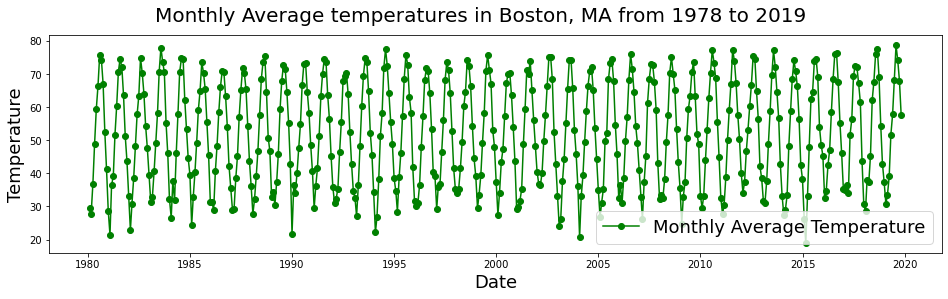

In [10]:
#Plot the data set
fig = plt.figure(figsize=(16,4))
fig.suptitle('Monthly Average temperatures in Boston, MA from 1978 to 2019',fontsize=20)
actual, = plt.plot(df.index, df['TAVG'], 'go-', label='Monthly Average Temperature')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Temperature',fontsize=18)
plt.legend(handles=[actual],fontsize=18)
#plt.savefig('images/avetemp.png',bbox_inches='tight')
plt.show()

Now, we calculate the lag variables:

In [11]:
#Make a copy
df_lagged = df.copy()
#Add time lagged columns to the data set
for i in range(1, 13, 1):
	df_lagged['TAVG_LAG_' + str(i)] = df_lagged['TAVG'].shift(i)

In [12]:
#Drop the NaN rows
for i in range(0, 12, 1):
	df_lagged = df_lagged.drop(df_lagged.index[0])

print(df_lagged.head())

                 TAVG  TAVG_LAG_1  TAVG_LAG_2  TAVG_LAG_3  TAVG_LAG_4  \
DATE                                                                    
1981-01-31  21.419355   28.596774   41.216667   52.354839   66.933333   
1981-02-28  36.392857   21.419355   28.596774   41.216667   52.354839   
1981-03-31  39.080645   36.392857   21.419355   28.596774   41.216667   
1981-04-30  51.666667   39.080645   36.392857   21.419355   28.596774   
1981-05-31  60.419355   51.666667   39.080645   36.392857   21.419355   

            TAVG_LAG_5  TAVG_LAG_6  TAVG_LAG_7  TAVG_LAG_8  TAVG_LAG_9  \
DATE                                                                     
1981-01-31   74.177419   75.806452   66.300000   59.387097   48.716667   
1981-02-28   66.933333   74.177419   75.806452   66.300000   59.387097   
1981-03-31   52.354839   66.933333   74.177419   75.806452   66.300000   
1981-04-30   41.216667   52.354839   66.933333   74.177419   75.806452   
1981-05-31   28.596774   41.216667   52.3548

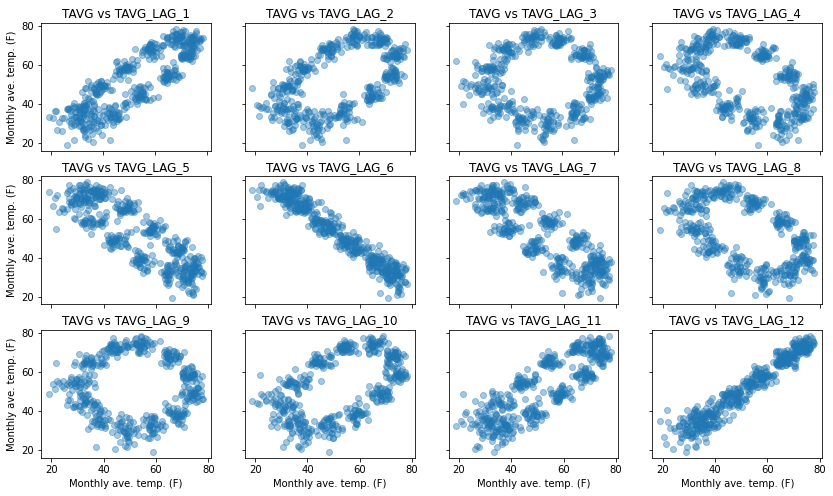

In [13]:

fig, axs = plt.subplots(3, 4, figsize=(14,8))
axs[0, 0].scatter(df_lagged.TAVG_LAG_1, df_lagged.TAVG,alpha=.4)
axs[0, 0].set_title('TAVG vs TAVG_LAG_1')
axs[0, 1].scatter(df_lagged.TAVG_LAG_2, df_lagged.TAVG,alpha=.4)
axs[0, 1].set_title('TAVG vs TAVG_LAG_2')
axs[0, 2].scatter(df_lagged.TAVG_LAG_3, df_lagged.TAVG,alpha=.4)
axs[0, 2].set_title('TAVG vs TAVG_LAG_3')
axs[0, 3].scatter(df_lagged.TAVG_LAG_4, df_lagged.TAVG,alpha=.4)
axs[0, 3].set_title('TAVG vs TAVG_LAG_4')

axs[1, 0].scatter(df_lagged.TAVG_LAG_5, df_lagged.TAVG,alpha=.4)
axs[1, 0].set_title('TAVG vs TAVG_LAG_5')
axs[1, 1].scatter(df_lagged.TAVG_LAG_6, df_lagged.TAVG,alpha=.4)
axs[1, 1].set_title('TAVG vs TAVG_LAG_6')
axs[1, 2].scatter(df_lagged.TAVG_LAG_7, df_lagged.TAVG,alpha=.4)
axs[1, 2].set_title('TAVG vs TAVG_LAG_7')
axs[1, 3].scatter(df_lagged.TAVG_LAG_8, df_lagged.TAVG,alpha=.4)
axs[1, 3].set_title('TAVG vs TAVG_LAG_8')

axs[2, 0].scatter(df_lagged.TAVG_LAG_9, df_lagged.TAVG,alpha=.4)
axs[2, 0].set_title('TAVG vs TAVG_LAG_9')
axs[2, 1].scatter(df_lagged.TAVG_LAG_10, df_lagged.TAVG,alpha=.4)
axs[2, 1].set_title('TAVG vs TAVG_LAG_10')
axs[2, 2].scatter(df_lagged.TAVG_LAG_11, df_lagged.TAVG,alpha=.4)
axs[2, 2].set_title('TAVG vs TAVG_LAG_11')
axs[2, 3].scatter(df_lagged.TAVG_LAG_12, df_lagged.TAVG,alpha=.4)
axs[2, 3].set_title('TAVG vs TAVG_LAG_12')


for ax in axs.flat:
   ax.set(xlabel='Monthly ave. temp. (F)', ylabel='Monthly ave. temp. (F)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
   ax.label_outer()

#fig.savefig('images/lagscatter.png',bbox_inches='tight')

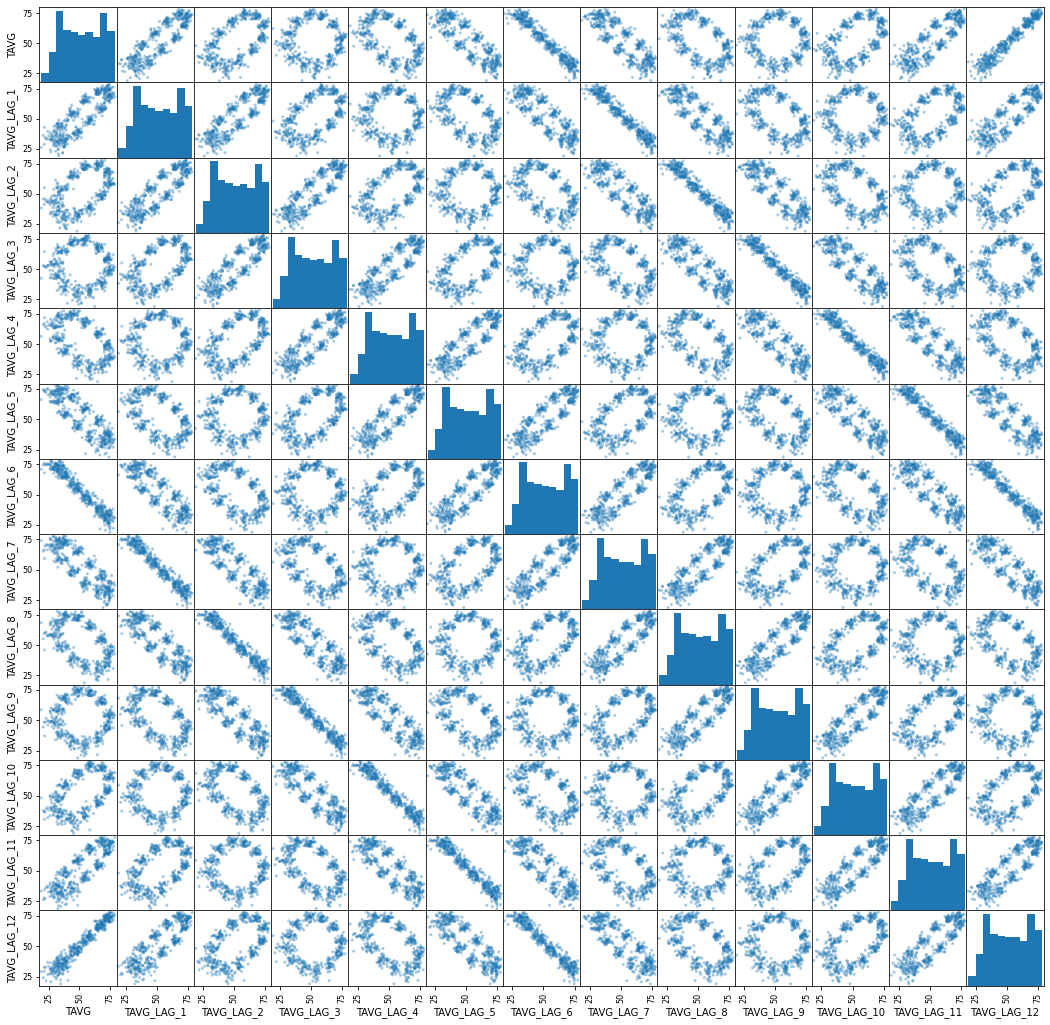

In [14]:
pd.plotting.scatter_matrix(df_lagged,alpha=0.4,figsize=(18,18) );
fig = plt.gcf()
#fig.savefig('images/lagscatter2.png',bbox_inches='tight')

In [15]:
#Carve out the test and the training data sets
split_index = round(len(df_lagged)*0.8)
split_date = df_lagged.index[split_index]
df_train = df_lagged.loc[df_lagged.index <= split_date].copy()
df_test = df_lagged.loc[df_lagged.index > split_date].copy()

In [16]:
X_train = df_train.iloc[:,1:]
X_test = df_test.iloc[:,1:]
y_train = df_train.iloc[:,0]
y_test = df_test.iloc[:,0]

### (a) Forward/backward stepwise selection

Best subset selection was shown in an earlier example in L2b. Here, we perform forward stepwise selection.

In [17]:
#Ref: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#methods
lm = LinearRegression()
fss = SFS(lm, k_features = (1,12),  forward=True, floating=False, scoring='neg_mean_squared_error',cv=5)
fss = fss.fit(X_train, y_train)

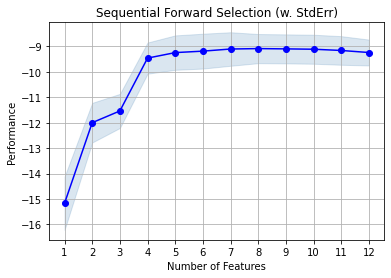

In [18]:
fig = plot_sfs(fss.get_metric_dict(), kind='std_err')
#plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

Eight features are in the best subset found by forward stepwise selection:

In [19]:
fss.k_feature_idx_

(0, 1, 3, 4, 5, 8, 10, 11)

These are the features (variables) in the best subset:

In [20]:
print(fss.k_feature_names_)

('TAVG_LAG_1', 'TAVG_LAG_2', 'TAVG_LAG_4', 'TAVG_LAG_5', 'TAVG_LAG_6', 'TAVG_LAG_9', 'TAVG_LAG_11', 'TAVG_LAG_12')


In [21]:
fss.k_score_ #negative MSE

-9.086952179719905

In [22]:
X_train_fss = fss.transform(X_train)
X_test_fss = fss.transform(X_test)

In [26]:
fss_lm = lm.fit(X_train_fss, y_train)

The coefficients are:

In [27]:
fss_lm.coef_

array([ 0.31933824,  0.12979467, -0.0620899 , -0.12959973, -0.22107283,
        0.06345856,  0.16810543,  0.13858707])

The intercept is:

In [28]:
fss_lm.intercept_

30.733206372521206

Then, we can write the estimated equation as:

$\hat{y} = 30.73 + 0.32y_{t-1} + 0.13y_{t-2} - 0.06y_{t-4} - 0.13y_{t-5} - 0.22y_{t-6} + 0.06y_{t-9} + 0.17y_{t-11} + 0.14y_{t-12}$

where $t$ is the time in months and $y$ is the monthly average temperature. According to this model, the monthly average temperature is expected to increaseby 0.32F for each 1F increase in the temperature of the previous month and decrease by 0.22F for a unit increase in the temperature 6 months ago, and so on. Given the annual cycle of temperatures, the signs of the coefficients are reasonable.

We compute the RMSE on the test set:

In [32]:
y_pred = fss_lm.predict(X_test_fss)

In [33]:
np.sqrt(np.mean((y_test.to_list() - y_pred)**2))

3.3322665747515114

This is 3.3F. Thus, the model error is approximately 3 degrees Fahrenheit off on average (quite good).

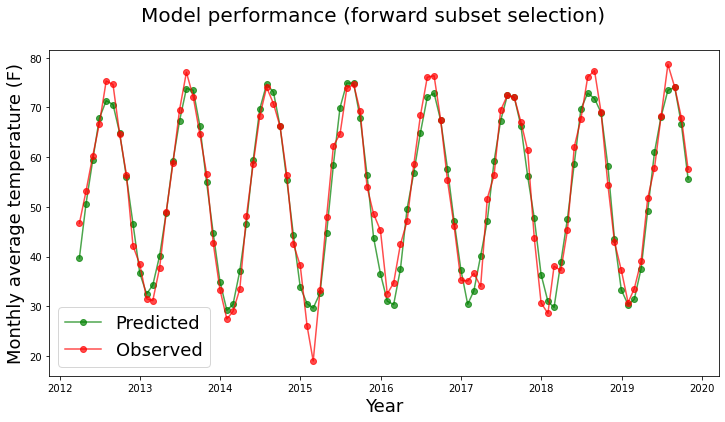

In [34]:
#Plot the actual versus predicted values of TAVG on the test data set
fig = plt.figure(figsize=(12,6))
fig.suptitle('Model performance (forward subset selection)',fontsize=20)
predicted, = plt.plot(X_test.index, y_pred, 'go-', label='Predicted',alpha=.7)
actual, = plt.plot(X_test.index, y_test, 'ro-', label='Observed',alpha=.7)
plt.legend(handles=[predicted, actual],fontsize=18)
plt.xlabel('Year',fontsize=18)
plt.ylabel('Monthly average temperature (F)',fontsize=18)
plt.show()

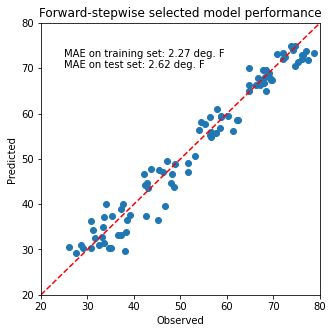

In [45]:
y_pred_train_fss = fss_lm.predict(X_train_fss)
y_pred_fss = lm.predict(X_test_fss)
mae_train = mean_absolute_error(y_train, y_pred_train_fss)
string_score = f'MAE on training set: {mae_train:.2f} deg. F'
mae_test = mean_absolute_error(y_test, y_pred_fss)
string_score += f'\nMAE on test set: {mae_test:.2f} deg. F'
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred_fss)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(25, 70, string_score)
plt.title('Forward-stepwise selected model performance')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.xlim([20, 80])
_ = plt.ylim([20, 80])

### (b) Ridge regression

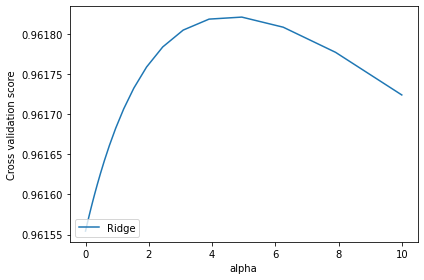

In [36]:
alphas = np.logspace(-4, 1, 50)

X_train_scaled = scale(df_train.iloc[:,1:])
X_test_scaled = scale(df_test.iloc[:,1:])

ridge_scores = [cross_val_score(Ridge(alpha), X_train_scaled, y_train, cv = 5).mean() for alpha in alphas]

plt.plot(alphas, ridge_scores, label = 'Ridge')
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('Cross validation score')
plt.tight_layout()
plt.show()


In [37]:
features = X_train.columns

In [38]:
opt_ridge_alpha = alphas[np.argmax(ridge_scores)]
print(opt_ridge_alpha)

4.941713361323838


In [39]:
ridge_model = Ridge(opt_ridge_alpha)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [40]:
ridge_model.intercept_

51.63238118535917

In [41]:
ridge_coefs = pd.DataFrame(ridge_model.coef_, columns = ['Coefficients'], index = features)
# add intercept
# ridge_coefs.loc['Intercept', 'Coefficients'] = ridge_model.intercept_

In [42]:
ridge_coefs = ridge_coefs.sort_values(by='Coefficients')

Text(0.5, 1.0, 'Ridge model coefficients (scaled)')

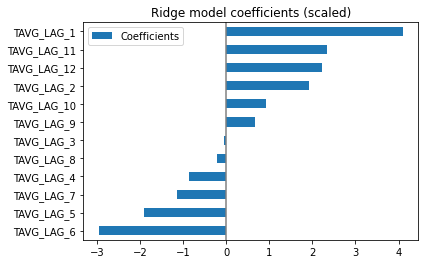

In [43]:
ridge_coefs.plot(kind = 'barh')
plt.axvline(x=0, color='.5')
plt.title('Ridge model coefficients (scaled)')

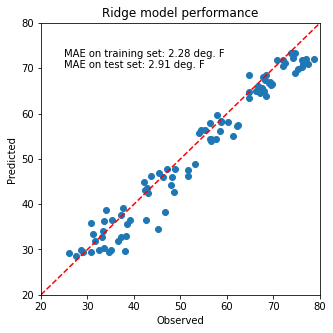

In [44]:
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train_ridge)
string_score = f'MAE on training set: {mae_train:.2f} deg. F'
mae_test = mean_absolute_error(y_test, y_pred_ridge)
string_score += f'\nMAE on test set: {mae_test:.2f} deg. F'
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred_ridge)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(25, 70, string_score)
plt.title('Ridge model performance')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.xlim([20, 80])
_ = plt.ylim([20, 80])

This is a reasonably good fit to the data.  We can write the equation (based on the scaled data) as:

In [46]:
print(f'TAVG = {ridge_model.intercept_:.2f} \
+ {ridge_model.coef_[0]:.2f}*TAVG_LAG_1_SCALED \
+ {ridge_model.coef_[1]:.2f}*TAVG_LAG_2_SCALED \
+ {ridge_model.coef_[2]:.2f}*TAVG_LAG_3_SCALED \
+ {ridge_model.coef_[3]:.2f}*TAVG_LAG_4_SCALED \
+ {ridge_model.coef_[4]:.2f}*TAVG_LAG_5_SCALED \
+ {ridge_model.coef_[5]:.2f}*TAVG_LAG_6_SCALED \
+ {ridge_model.coef_[6]:.2f}*TAVG_LAG_7_SCALED \
+ {ridge_model.coef_[7]:.2f}*TAVG_LAG_8_SCALED \
+ {ridge_model.coef_[8]:.2f}*TAVG_LAG_9_SCALED \
+ {ridge_model.coef_[9]:.2f}*TAVG_LAG_10_SCALED \
+ {ridge_model.coef_[10]:.2f}*TAVG_LAG_11_SCALED \
+ {ridge_model.coef_[11]:.2f}*TAVG_LAG_12_SCALED')

TAVG = 51.63 + 4.10*TAVG_LAG_1_SCALED + 1.92*TAVG_LAG_2_SCALED + -0.06*TAVG_LAG_3_SCALED + -0.87*TAVG_LAG_4_SCALED + -1.92*TAVG_LAG_5_SCALED + -2.97*TAVG_LAG_6_SCALED + -1.15*TAVG_LAG_7_SCALED + -0.23*TAVG_LAG_8_SCALED + 0.66*TAVG_LAG_9_SCALED + 0.91*TAVG_LAG_10_SCALED + 2.34*TAVG_LAG_11_SCALED + 2.22*TAVG_LAG_12_SCALED


If we would like to interpret the coefficients directly (e.g. how much would the temperature change by a unit change in any of the monthly lags), we can convert them by dividing each coefficient by the respective standard deviation of the lag variable.

### 2(b) Lasso regression

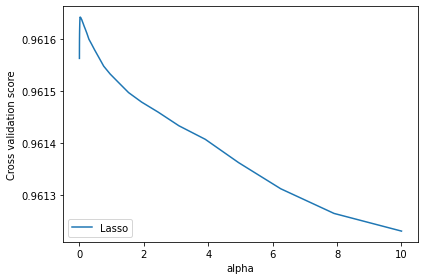

In [47]:
lasso_alphas = np.logspace(-3, -1, 50)
lasso_scores = [cross_val_score(Lasso(alpha), X_train_scaled, y_train, cv = 5).mean() for alpha in lasso_alphas]

plt.plot(alphas, lasso_scores, label = 'Lasso')
plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('Cross validation score')
plt.tight_layout()
plt.show()

In [48]:
opt_lasso_alpha = alphas[np.argmax(lasso_scores)]
print(opt_lasso_alpha)

0.022229964825261957


In [49]:
lasso_model = Lasso(opt_lasso_alpha)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.022229964825261957)

In [50]:
lasso_model.coef_

array([ 4.81521047,  1.50573297, -0.        , -0.6265785 , -1.96691151,
       -3.38882759, -0.49074389, -0.        ,  0.43446053,  0.70352877,
        2.57997519,  2.06853308])

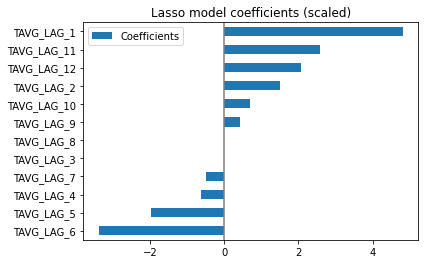

In [51]:
lasso_coefs = pd.DataFrame(lasso_model.coef_, columns = ['Coefficients'], index = features)
lasso_coefs = lasso_coefs.sort_values(by='Coefficients')
lasso_coefs.plot(kind = 'barh')
plt.axvline(x=0, color='.5')
_ = plt.title('Lasso model coefficients (scaled)')

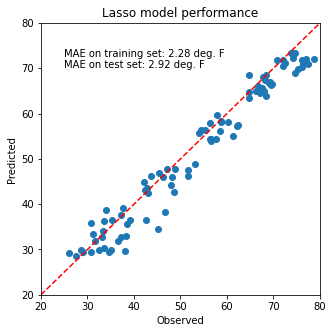

In [52]:
y_pred_train_lasso = lasso_model.predict(X_train_scaled)
y_pred_lasso = lasso_model.predict(X_test_scaled)

mae_train = mean_absolute_error(y_train, y_pred_train_lasso)
string_score = f'MAE on training set: {mae_train:.2f} deg. F'
mae_test = mean_absolute_error(y_test, y_pred_lasso)
string_score += f'\nMAE on test set: {mae_test:.2f} deg. F'
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred_ridge)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(25, 70, string_score)
plt.title('Lasso model performance')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.xlim([20, 80])
_ = plt.ylim([20, 80])

### 2 (c) Performance summary

In [53]:
lasso_metrics = [mean_absolute_error(y_test, y_pred_lasso), median_absolute_error(y_test, y_pred_lasso),  np.sqrt(mean_squared_error(y_test, y_pred_lasso))]
ridge_metrics = [mean_absolute_error(y_test, y_pred_ridge), median_absolute_error(y_test, y_pred_ridge), np.sqrt(mean_squared_error(y_test, y_pred_ridge))]
fss_metrics = [mean_absolute_error(y_test, y_pred_fss), median_absolute_error(y_test, y_pred_fss),  np.sqrt(mean_squared_error(y_test, y_pred_fss))]

In [54]:
metrics_df = pd.DataFrame([fss_metrics, ridge_metrics, lasso_metrics], columns  = ['Mean abs error (F)', 'Med. abs error (F)', 'Root mean squared error (F)'], index = ['FSS', 'Ridge', 'Lasso'])

In [55]:
np.round(metrics_df,2)

,Mean abs error (F),Med. abs error (F),Root mean squared error (F)
FSS,2.62,2.17,3.33
Ridge,2.91,2.31,3.71
Lasso,2.92,2.38,3.68


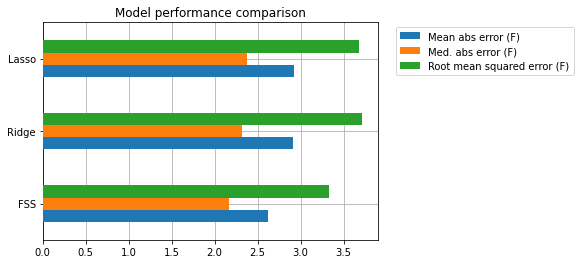

In [61]:
metrics_df.plot(kind='barh',zorder=100)
plt.title('Model performance comparison')
plt.grid(zorder = 0)
plt.legend(loc=1, bbox_to_anchor=(1.6,1))

We see that in this case, the model estimated based on the variables determined by forward stepwise selection (FSS) performed the best. The Lasso and Ridge models could be parameterized for potentially better performance by using other criteria (e.g. AIC/BIC) to select the optimal regularization (alpha).

## Problem 4: Logistic regression

In [62]:
ddf = pd.read_csv('data/Default.csv', index_col=0)
#ddf.student = ddf.student.map(dict(Yes=1, No=0))
X_train, X_test, y_train, y_test = train_test_split(ddf.iloc[:,2:], ddf.default, test_size=.1, random_state = 1, stratify = ddf.default)

Play around with the `test_size` parameter in `train_test_split`. Given the small number of positive observations, a much smaller test split (e.g. 1%) will result in a much better fit to the data (albeit leaning toward an overfit).

In [63]:
X_train.head() #always check your data

,balance,income
244,1964.476872,39054.589144
3843,1028.181249,32249.845672
7669,1005.623009,43471.780321
5967,272.219928,47757.824408
7573,463.045456,35621.080350


In [64]:
X_test.head()

,balance,income
1852,682.712412,33175.183045
1055,1386.191949,42537.990793
154,95.296974,32359.389028
7554,763.773764,60938.664099
6492,343.768806,51626.135693


### 4 (a) estimate logistic regression model

In [65]:
logistic = LogisticRegression() #penalty='none')
logistic.fit(X_train, y_train) #using only balance and income

LogisticRegression()

In [66]:
logistic.intercept_

array([-1.08905609e-06])

In [83]:
logistic.feature_names_in_

array(['balance', 'income'], dtype=object)

In [67]:
logistic.coef_

array([[ 0.00038273, -0.00012459]])

We can then write the estimated equation as:

$ p(X) = \dfrac{1}{1 + \exp(1.8\cdot 10^{-6} - 0.0004x_1 + 0.00013x_2)}$

where $p(X)$ is the probability of default, $x_1$ is balance and $x_2$ is income.

### 4 (c) Scatter plot and decision boundary

At the decision boundary, the probability of default equals 0.5. Thus, line is defined as the logit link function equated to the log-odds, $\ln(\frac{p}{1-p})$. Thus:

\begin{align}
\ln \left(\frac{p}{1-p}\right) &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 \\
\beta_2 x_2 &= -\beta_0 - \beta_1 x_1 + \ln \left(\frac{p}{1-p}\right) \\
x_2 &= \frac{1}{\beta_2} \Big( \ln \left(\frac{p}{1-p}\right)  - \beta_0 - \beta_1 x_1  \Big)
\end{align}

We see from the above equation of the decision boundary that if $p = 0.5$, then the log-odds is 1. Thus:

\begin{equation}
x_2 = -\frac{1}{\beta_2} \Big(\beta_0 + \beta_1 x_1 \Big), \quad  p = 0.5
\end{equation}

Text(0.5, 1.0, 'Logistic regression boundary at p = 0.5')

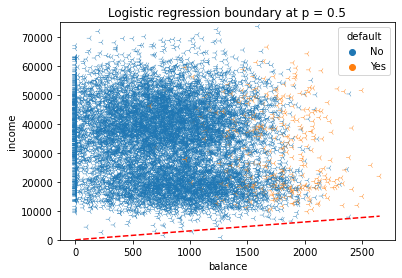

In [70]:
sns.scatterplot(x = ddf.balance, y = ddf.income, hue = ddf.default, alpha = .9, marker='3' )
x = np.linspace(0, np.max(ddf.balance), 100)
y = -(1 / logistic.coef_[0,1])*(logistic.intercept_[0] + logistic.coef_[0,0]*x)
plt.plot(x, y, color='r', ls='--')
plt.ylim(0,75000)
plt.title('Logistic regression boundary at p = 0.5')

The decision boundary indicates that this is a poorly-fitting model. We can clearly see that no "Yes" lies to the "right" side of the boundary (indicating zero recall).

### 4 (d) error rate, recall and precision

In [71]:
y_pred = logistic.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.97
              precision    recall  f1-score   support

          No       0.97      1.00      0.98       967
         Yes       0.00      0.00      0.00        33

    accuracy                           0.97      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.94      0.97      0.95      1000



/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The error rate is 0.03, while the precision and recall are both 0 (with respect to the positive class). This means the model fails to predict a single positive observation correctly in the test set.

In [72]:
def plot_confusion_matrix(con_mat, class_labels, normalize = False):
    if normalize==True:
        con_mat = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    else:
        pass
    con_mat_df = pd.DataFrame(con_mat, index = class_labels, columns = class_labels)
    figure = plt.figure()#figsize=(4, 4))    ## Confusion matrix heatmap
    ax = sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, fmt='g', cbar = False, annot_kws={"size": 16})
    #figure.tight_layout()
    plt.ylabel('True',fontsize=16)
    ax.set_yticklabels(class_labels,va='center',fontsize=14)
    ax.set_xticklabels(class_labels, ha='center',fontsize=14)
    plt.xlabel('Predicted',fontsize=16)
    return(con_mat_df)

### 4 (e) Plot confusion matrix

,No,Yes
No,967,0
Yes,33,0


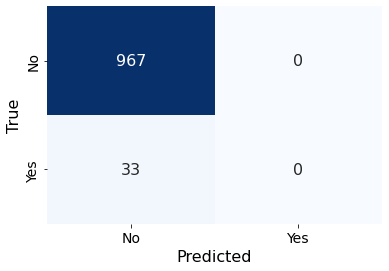

In [73]:
con_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(con_mat, ['No', 'Yes']) #, normalize = False)

To increase classifier sensitivity, I would lower the threshold of admitting to the positive class. We show the new decision boundary below. The model is still a poor fit, so the improvement is marginal (the sensitivity is merely increased to 0.03 from 0).

Text(0.5, 1.0, 'Logistic regression boundary at p = 0.3')

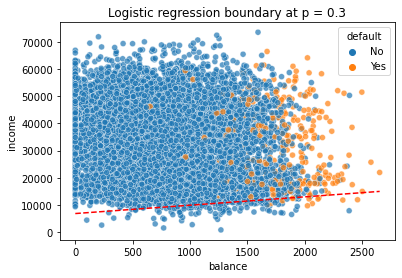

In [86]:
sns.scatterplot(x = ddf.balance, y = ddf.income, hue = ddf.default,alpha = .7 )
x = np.linspace(0, np.max(ddf.balance), 100)
y = (1 / logistic.coef_[0,1])*(np.log(0.3/0.7) -logistic.intercept_[0] - logistic.coef_[0,0]*x)
plt.plot(x, y, color='r', ls='--')
plt.title('Logistic regression boundary at p = 0.3')

In [89]:
X_test.iloc[:,:]

,balance,income
1852,682.712412,33175.183045
1055,1386.191949,42537.990793
154,95.296974,32359.389028
7554,763.773764,60938.664099
6492,343.768806,51626.135693
...,...,...
5160,544.143146,33861.553904
8599,1050.409386,16746.062821
1785,1370.109496,40101.379131
4492,1134.279848,37658.230956


In [92]:
y_pred_new_threshold = pd.Series((logistic.predict_proba(X_test.iloc[:,:])[:,1]>=0.3).astype(str))
y_pred_new_threshold = y_pred_new_threshold.map({'False': 'No', 'True': 'Yes'})
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

          No       0.97      0.99      0.98       967
         Yes       0.07      0.03      0.04        33

    accuracy                           0.95      1000
   macro avg       0.52      0.51      0.51      1000
weighted avg       0.94      0.95      0.95      1000



### 3 (g) ROC curve and AUC

/usr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


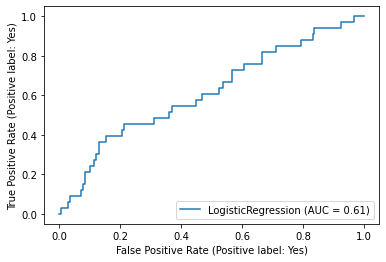

In [94]:
plot_roc_curve(logistic, X_test.iloc[:,:], y_test)  

From the plot, we see that the AUC is 0.57.

### 3 (h) Extra credit

If the default is independent of either balance or income, then we would expect the ROC curve to be a straight 45-degree line, as any prediction would be a random guess between 'Yes' and 'No'. This line is also known as the "line of no discrimination" (with an AUC of 0.50). A decent classifer should have a much higher value than this threshold.

## Problem 4b: LDA

In [98]:
X_train

,balance,income
244,1964.476872,39054.589144
3843,1028.181249,32249.845672
7669,1005.623009,43471.780321
5967,272.219928,47757.824408
7573,463.045456,35621.080350
...,...,...
6499,453.929799,12665.306995
4302,677.204839,52080.523362
7198,171.598895,24809.114525
1015,80.752864,35887.546361


In [99]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train.iloc[:,:], y_train) #using only balance and income

LinearDiscriminantAnalysis()

Accuracy of LDA classifier on test set: 0.97
              precision    recall  f1-score   support

          No       0.98      1.00      0.99       967
         Yes       0.80      0.36      0.50        33

    accuracy                           0.98      1000
   macro avg       0.89      0.68      0.74      1000
weighted avg       0.97      0.98      0.97      1000



,No,Yes
No,964,3
Yes,21,12


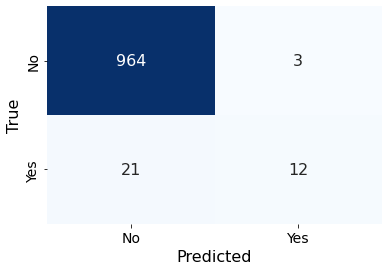

In [102]:
y_pred_lda = lda.predict(X_test.iloc[:,:])
print('Accuracy of LDA classifier on test set: {:.2f}'.format(logistic.score(X_test.iloc[:,:], y_test)))
print(classification_report(y_test, y_pred_lda))
con_mat_lda = confusion_matrix(y_test, y_pred_lda)
plot_confusion_matrix(con_mat_lda, ['No', 'Yes']) #, normalize = False)

We see that the basic LDA classifier has a precision of 0.83 (a significant improvement over logistic) but still relatively low recall of 0.30. We plot the boundary (a bit involved):

In [154]:
N = 300
X = np.linspace(0, 2500, N)
Y = np.linspace(0, 70000, N)
X, Y = np.meshgrid(X, Y)

#Compute the predicted class function for each value on the grid
zz = np.array([lda.predict(pd.DataFrame(np.array([xx,yy]).reshape(1,-1), columns = ['balance','income'])) for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
#zz = np.array(  [lda.predict(np.array([xx,yy]).reshape(1,-1)) for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )

In [155]:
zz2 = np.unique(zz, return_inverse=True)[1] # convert zz to numeric labels

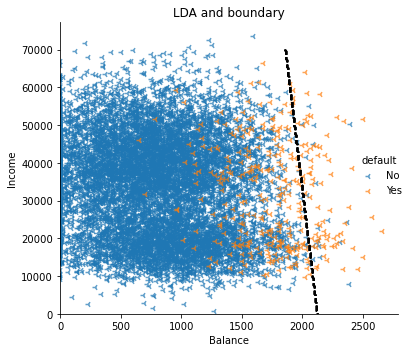

In [156]:
g = sns.FacetGrid(ddf, hue="default", height=5)#, palette = 'colorblind')
g.map(plt.scatter, "balance", "income", marker = '3', alpha=.7)  
g.add_legend()
my_ax = g.ax 
Z = zz2.reshape(X.shape)
my_ax.contour( X, Y, Z,  alpha = 1, colors='black', linestyles= 'dashed') #Plot the filled and boundary contours
my_ax.set_xlabel('Balance')
my_ax.set_ylabel('Income')
my_ax.set_title('LDA and boundary')
plt.tight_layout()
plt.savefig('lda.png',dpi=200)

The boundary indicates that the LDA provides a better-fitting model.

## Problem 6: Cross-validation

To implement CV efficiently across these models, we use the nifty `cross_val_score` function:

In [139]:
knn = KNeighborsClassifier(n_neighbors = 5)
yes_recall = make_scorer(recall_score, pos_label='Yes')  # we have use make_scorer in order to modify the default positive label (which is 1)
knn_scores = cross_validate(knn, X_train.iloc[:,:], y_train, cv=5 , scoring=yes_recall)   

In [140]:
lda_scores = cross_validate(lda, X_train.iloc[:,:], y_train, cv=5 , scoring=yes_recall)  

In [141]:
logr_scores = cross_validate(logistic, X_train.iloc[:,:], y_train, cv=5 , scoring=yes_recall)  

In [142]:
qda = QuadraticDiscriminantAnalysis()
qda_scores = cross_validate(qda, X_train.iloc[:,:], y_train, cv=5 , scoring=yes_recall)  

In [143]:
qda_scores['test_score'].mean()

0.25

In [144]:
cv_scores_df = pd.DataFrame([knn_scores['test_score'].mean(), logr_scores['test_score'].mean(), lda_scores['test_score'].mean(), qda_scores['test_score'].mean()], columns = ['Recall'],
                           index = ['KNN', 'Logistic', 'LDA', 'QDA'])

In [145]:
cv_scores_df

,Recall
KNN,0.096667
Logistic,0.140000
LDA,0.220000
QDA,0.250000


<AxesSubplot:>

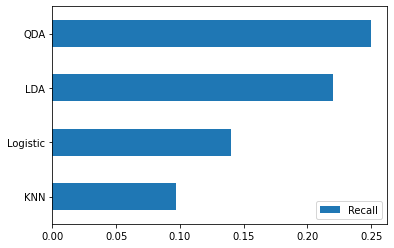

In [146]:
cv_scores_df.plot(kind='barh')

Based on the cross-validation results, QDA results in the highest sensitivity (recall). Note that we have done a three-way partitioning (train/validate/test). We have reserved an untouched test set for real-world performance of the selected model.